In [1]:
import sys
sys.path.insert(0, '..')

from AttentionModule import Conv2d_Attn

import torch
from torch import nn
from torchvision import models, datasets, transforms
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms

import re
import numpy as np

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [2]:
batch_size = 32
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose(
    [transforms.ToTensor(),
     normalize])

trainset = torchvision.datasets.ImageFolder(root='../data/train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [3]:
resnet50 = torch.load('../4-29-Top3/new_attn.pkl')

In [4]:
resnet50 = resnet50.eval().cuda()

In [5]:
res50_pre_pool_outs = []
for batch, _ in tqdm(iter(trainloader)):
    out = Variable(batch).cuda()
    for i, layer in enumerate(list(resnet50.children())):
        if isinstance(layer, torch.nn.modules.linear.Linear):
            out = out.view(out.size(0), -1)
        out = layer(out)
        if i == 8:
            res50_pre_pool_outs.append(out.squeeze().data.cpu().numpy())
            break

100%|██████████| 256/256 [01:03<00:00,  4.00it/s]


In [6]:
res50_pre_pool_outs = np.vstack(res50_pre_pool_outs)
res50_centroid = res50_pre_pool_outs.mean(axis=0).reshape(1,-1)
res50_l2_dist = ((res50_pre_pool_outs - res50_centroid)**2).sum(axis=1)
sum(res50_l2_dist)/len(trainset)

2171.372225633922

In [7]:
trainset = torchvision.datasets.ImageFolder(root='../data/coco', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [8]:
coco_pre_pool_outs = []
for batch, _ in tqdm(iter(trainloader)):
    out = Variable(batch).cuda()
    for i, layer in enumerate(list(resnet50.children())):
        if isinstance(layer, torch.nn.modules.linear.Linear):
            out = out.view(out.size(0), -1)
        out = layer(out)
        if i == 8:
            coco_pre_pool_outs.append(out.squeeze().data.cpu().numpy())
            break

100%|██████████| 54/54 [00:13<00:00,  3.95it/s]


In [9]:
coco_pre_pool_outs = np.vstack(coco_pre_pool_outs)
coco_centroid = coco_pre_pool_outs.mean(axis=0).reshape(1,-1)
coco_l2_dist = ((coco_pre_pool_outs - coco_centroid)**2).sum(axis=1)
sum(coco_l2_dist)/len(trainset)

2797.811445627429

In [10]:
from sklearn.decomposition import PCA

In [11]:
amph = PCA(50).fit_transform(res50_pre_pool_outs)
coco = PCA(50).fit_transform(coco_pre_pool_outs)

In [12]:
amph.shape

(8161, 50)

In [13]:
coco.shape

(1721, 50)

In [14]:
from sklearn.manifold import TSNE

In [15]:
amph_sample = res50_pre_pool_outs[np.random.choice(np.arange(len(amph)), size=500)]
coco_sample = coco_pre_pool_outs[np.random.choice(np.arange(len(coco)), size=500)]

In [16]:
amph_sample.shape

(500, 2048)

In [17]:
coco_sample.shape

(500, 2048)

In [18]:
# just_amph = TSNE().fit_transform(amph_sample)

In [19]:
# just_coco = TSNE().fit_transform(coco_sample)

In [20]:
both = TSNE().fit_transform(np.vstack([amph_sample, coco_sample]))

In [21]:
def scatter(arr):
    plt.scatter(arr[:,0], arr[:,1])

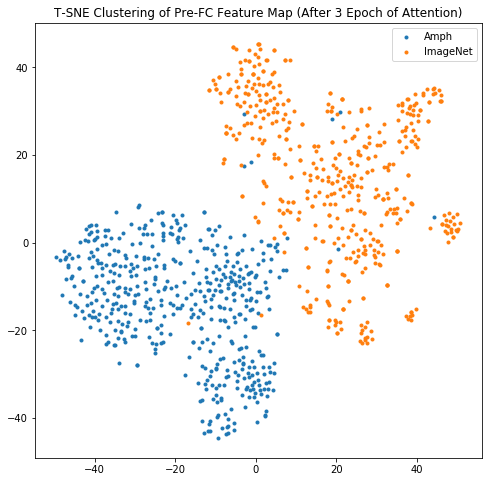

In [22]:
plt.figure(figsize=(8,8))
plt.scatter(both[:500,0], both[:500,1], label='Amph', marker='.')
plt.scatter(both[500:,0], both[500:,1], label='ImageNet', marker='.')
plt.legend()
plt.title("T-SNE Clustering of Pre-FC Feature Map (After 3 Epoch of Attention)")
plt.savefig('../imgs/tsne-attention.png', dpi=400)